<a href="https://colab.research.google.com/github/thiagoribeiro00/neuroscience-computational/blob/main/snns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalando as dependencias

In [ ]:
pip install snntorch torch torchvision matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.4 MB/s eta 0:00:00


### Importando as dependencias

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from snntorch import spikegen
from snntorch import functional as SF
from snntorch import utils
import matplotlib.pyplot as plt
import snntorch as snn

### Preparando dados

In [ ]:
# Hiperparâmetros
batch_size = 128
num_steps = 25  # Passos temporais para simular os spikes

# Transformações: converte imagens em tensores e normaliza
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

# Carregar dados MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 515kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


### Definindo a arquitetura do SNNs

In [ ]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Camada convolucional
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.lif1 = snn.Leaky(beta=0.9)  # Neurônio LIF com taxa de decaimento beta=0.9
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.lif2 = snn.Leaky(beta=0.9)
        # Calculate the correct input features for fc1
        # Assuming input size is 28x28
        # After conv1: (28 - 5 + 1) = 24
        # After conv2: (24 - 5 + 1) = 20
        # Flattened size: 16 * 20 * 20 = 6400
        self.fc1 = nn.Linear(6400, 10)  # Changed input features to 6400
        self.lif3 = snn.Leaky(beta=0.9)

    def forward(self, x):
        # Reinicia os estados dos neurônios
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Registra os spikes de saída
        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            # Processa cada passo temporal
            x_step = x[step]  # Dados do passo atual
            cur1 = self.conv1(x_step)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            # Flatten spk2 before passing it to the fully connected layer
            # and make sure the number of features matches the input size of the
            # fully connected layer.
            cur3 = self.fc1(spk2.view(spk2.size(0), -1)) # The output of conv2 is flattened and passed to fc1
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

### Definindo a função de custo do otimizador

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = SNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

### Treinando a SNN

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Converte imagens em trens de spikes
        images = spikegen.rate(images, num_steps=num_steps).to(device)
        labels = labels.to(device)

        # Forward pass
        spk_rec, mem_rec = model(images)

        # Calcula a perda
        loss = loss_fn(spk_rec, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/469], Loss: 0.2245
Epoch [1/5], Step [200/469], Loss: 0.1417
Epoch [1/5], Step [300/469], Loss: 0.1642
Epoch [1/5], Step [400/469], Loss: 0.1278
Epoch [2/5], Step [100/469], Loss: 0.1082
Epoch [2/5], Step [200/469], Loss: 0.1416
Epoch [2/5], Step [300/469], Loss: 0.1172
Epoch [2/5], Step [400/469], Loss: 0.1229
Epoch [3/5], Step [100/469], Loss: 0.1218
Epoch [3/5], Step [200/469], Loss: 0.0987
Epoch [3/5], Step [300/469], Loss: 0.0974
Epoch [3/5], Step [400/469], Loss: 0.1082
Epoch [4/5], Step [100/469], Loss: 0.0972
Epoch [4/5], Step [200/469], Loss: 0.0817
Epoch [4/5], Step [300/469], Loss: 0.0962
Epoch [4/5], Step [400/469], Loss: 0.0896
Epoch [5/5], Step [100/469], Loss: 0.0957
Epoch [5/5], Step [200/469], Loss: 0.0730
Epoch [5/5], Step [300/469], Loss: 0.0773
Epoch [5/5], Step [400/469], Loss: 0.0943


### Avavaliando o modelo

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = spikegen.rate(images, num_steps=num_steps).to(device)
        labels = labels.to(device)
        spk_rec, _ = model(images)

        # Predição: neurônio com mais spikes ao longo do tempo
        _, predicted = spk_rec.sum(dim=0).max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Acurácia no conjunto de teste: {accuracy:.2f}%')

Acurácia no conjunto de teste: 98.32%


Vizualizar os spikes


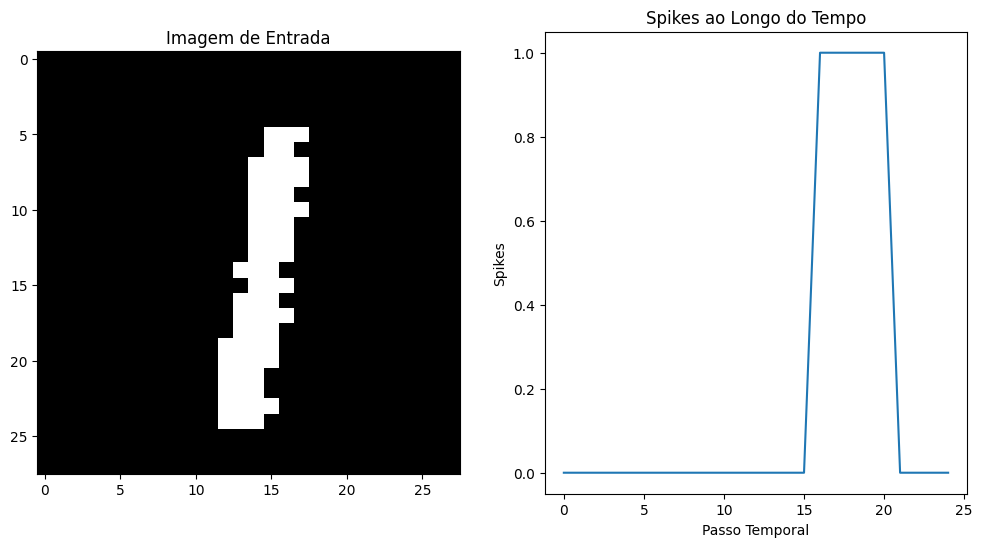

In [ ]:
# Exemplo de visualização de spikes em um neurônio
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(images[0][0].cpu().numpy().squeeze(), cmap='gray')
plt.title('Imagem de Entrada')

plt.subplot(1, 2, 2)
plt.plot(spk_rec[:, 0, 0].cpu().numpy())  # Spikes do primeiro neurônio
plt.title('Spikes ao Longo do Tempo')
plt.xlabel('Passo Temporal')
plt.ylabel('Spikes')
plt.show()